Este es el segundo notebook que comprende el proceso de trabajo para el proyecto de Machine Learning.

El proyecto se inicia con los notebook "API_Digimonbase" del cual se extraen los datos de la API de Digimon.

En segundo lugar, se realiza el notebook "Cardmarket_price_guide_trabajo" del cual se extraen los datos del archivo json "products_singles_17.csv de Cardmarket.

Terceramente, se inician las pruebas limpieza de datos y análisis exploratorio de datos. Esto se desarrolla en el notebook "Primeras_pruebas_proyecto".
En el desarrollo de "Primeras_pruebas_proyecto", se realiza a su vez la creación del dataset final que se utilizará para el desarrollo del modelo y se da lugar a los primeros modelos, partiendo desde un modelo Random Forest Regressor, pasando por un modelo de Gradient Boosting Regressor y finalmente por un modelo CatBoost Regressor.

Tras analizar las métricas de los modelos, se procede a la creación del modelo híbrido que se desarrolla en el notebook "Modelo_híbrido". Para este modelo se tratarán por separado los datos de items "Premium" (Aquellos con mayor valor) y "Normal" (Aquellos con menor valor).

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  
from catboost import CatBoostRegressor, Pool

In [3]:
df_original = pd.read_csv('digimon_cards_with_prices_full.csv')

In [4]:
df_original.head()

,name_x,type,id,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,...,code,idExpansion,idMetacard,idCategory,avg,low,trend,avg1,avg7,avg30
0,A Blazing Storm of Metal!,Option,BT5-103,NaN,1.0,NaN,NaN,NaN,NaN,Black,...,BT5-103,4991.0,405558.0,1611.0,1.39,0.29,1.33,1.42,1.23,0.54
1,A Delicate Plan,Option,BT3-097,NaN,1.0,NaN,NaN,NaN,NaN,Red,...,BT3-097,4986.0,405325.0,1611.0,0.04,0.02,0.24,0.04,0.05,0.27
2,A New World,Option,P-021,NaN,0.0,NaN,NaN,NaN,NaN,Green,...,P-021,4996.0,405887.0,1611.0,0.53,0.30,0.44,0.41,0.63,0.86
3,Abbadomon,Digimon,EX9-055,6.0,11.0,3.0,NaN,NaN,Assembly Requirements [Assembly -6] 4 [Negamon...,Black,...,EX9-055,6142.0,450133.0,1611.0,0.11,0.02,0.11,0.02,0.15,0.15
4,Abbadomon Core,Digimon,EX9-057,7.0,15.0,5.0,NaN,NaN,[Digivolve] [Abbadomon]: Cost 4,Black,...,EX9-057,6142.0,450389.0,1611.0,4.96,3.90,5.00,6.95,5.00,5.65


In [8]:
# Aseguramos que avg es numérico
df_original['avg'] = pd.to_numeric(df_original['avg'], errors='coerce')

# Eliminamos filas sin precio
df_original = df_original.dropna(subset=['avg']).reset_index(drop=True)

# Normalizamos rarity a mayúsculas
df_original['rarity'] = df_original['rarity'].astype(str).str.upper()

# (Opcional pero recomendable) crear rarity_rank
rarity_order_map = {
    'C': 0,
    'U': 1,
    'R': 2,
    'P': 3,
    'SR': 4,
    'SEC': 5
}
df_original['rarity_rank'] = df_original['rarity'].map(rarity_order_map).fillna(-1).astype(int)

df_original[['rarity', 'rarity_rank', 'avg']].head()


,rarity,rarity_rank,avg
0,U,1,1.39
1,U,1,0.04
2,P,3,0.53
3,R,2,0.11
4,SR,4,4.96


In [9]:
if 'date_added' in df_original.columns:
    df_original['date_added'] = pd.to_datetime(df_original['date_added'], errors='coerce')
    df_original['year_added'] = df_original['date_added'].dt.year
    df_original['month_added'] = df_original['date_added'].dt.month


In [10]:
# Target en euros
y = df_original['avg']

# Partimos de todas las columnas y quitamos targets
cols_to_drop = ['avg_log', 'avg'] if 'avg_log' in df_original.columns else ['avg']
X = df_original.drop(columns=cols_to_drop, errors='ignore')

# Quitamos columnas problemáticas / IDs que llevan a sobreajuste
# Y las columnas de precio solicitadas
cols_to_exclude = ['id', 'date_added', 'low', 'trend', 'avg1', 'avg7', 'avg30']
for col in cols_to_exclude:
    if col in X.columns:
        X = X.drop(columns=[col])

X.head(), y.head()

(                      name_x     type  level  play_cost  evolution_cost  \
 0  A Blazing Storm of Metal!   Option    NaN        1.0             NaN   
 1            A Delicate Plan   Option    NaN        1.0             NaN   
 2                A New World   Option    NaN        0.0             NaN   
 3                  Abbadomon  Digimon    6.0       11.0             3.0   
 4             Abbadomon Core  Digimon    7.0       15.0             5.0   
 
   evolution_color  evolution_level  \
 0             NaN              NaN   
 1             NaN              NaN   
 2             NaN              NaN   
 3             NaN              NaN   
 4             NaN              NaN   
 
                                             xros_req  color color2  ...  \
 0                                                NaN  Black    NaN  ...   
 1                                                NaN    Red    NaN  ...   
 2                                                NaN  Green    NaN  ...   
 3

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Aseguramos rarity exista y esté en mayúsculas en ambos splits
for df_split in (X_train, X_test):
    if 'rarity' not in df_split.columns:
        df_split['rarity'] = df.loc[df_split.index, 'rarity']
    df_split['rarity'] = df_split['rarity'].astype(str).str.upper()



In [13]:
premium_rarities = ['SR', 'SEC', 'P']

premium_mask_train = (
    X_train['rarity'].isin(premium_rarities) &
    (y_train >= 3.0)
)

non_premium_mask_train = ~premium_mask_train

print("Cartas premium en train:", premium_mask_train.sum())
print("Cartas no premium en train:", non_premium_mask_train.sum())


Cartas premium en train: 191
Cartas no premium en train: 2716


In [15]:
# 1) Identificar columnas categóricas
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categóricas:", cat_cols)
print("Numéricas (primeras):", num_cols[:10])

# 2) Asegurar que NO hay NaN y que todo es string en las categóricas
for df_split in (X_train, X_test):
    df_split[cat_cols] = df_split[cat_cols].fillna("Unknown").astype(str)


Categóricas: ['name_x', 'type', 'evolution_color', 'xros_req', 'color', 'color2', 'digi_type', 'digi_type2', 'form', 'attribute', 'rarity', 'stage', 'main_effect', 'source_effect', 'alt_effect', 'series', 'pretty_url', 'tcgplayer_name', 'set_name', 'name_y', 'code']
Numéricas (primeras): ['level', 'play_cost', 'evolution_cost', 'evolution_level', 'dp', 'artist', 'tcgplayer_id', 'idProduct', 'idExpansion', 'idMetacard']


In [16]:
# Identificamos columnas categóricas para CatBoost
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categóricas:", cat_cols)
print("Numéricas (primeras):", num_cols[:10])

# Pool general: todas las cartas
train_pool_general = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_cols
)

valid_pool_general = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_cols
)

# Subconjunto premium
X_train_premium = X_train[premium_mask_train].copy()
y_train_premium = y_train[premium_mask_train].copy()

train_pool_premium = Pool(
    data=X_train_premium,
    label=y_train_premium,
    cat_features=cat_cols
)

print("Tamaño dataset premium:", X_train_premium.shape)


Categóricas: ['name_x', 'type', 'evolution_color', 'xros_req', 'color', 'color2', 'digi_type', 'digi_type2', 'form', 'attribute', 'rarity', 'stage', 'main_effect', 'source_effect', 'alt_effect', 'series', 'pretty_url', 'tcgplayer_name', 'set_name', 'name_y', 'code']
Numéricas (primeras): ['level', 'play_cost', 'evolution_cost', 'evolution_level', 'dp', 'artist', 'tcgplayer_id', 'idProduct', 'idExpansion', 'idMetacard']
Tamaño dataset premium: (191, 40)


In [17]:
model_general = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    n_estimators=2000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    od_type='Iter',
    od_wait=50,
    verbose=200
)

model_general.fit(
    train_pool_general,
    eval_set=valid_pool_general,
    use_best_model=True
)


0:	learn: 8.6501627	test: 3.1580806	best: 3.1580806 (0)	total: 174ms	remaining: 5m 48s
200:	learn: 0.6417780	test: 0.5945395	best: 0.5945395 (200)	total: 8.6s	remaining: 1m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5938709
bestIteration = 205

Shrink model to first 206 iterations.


In [18]:
model_premium = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    n_estimators=2000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    od_type='Iter',
    od_wait=50,
    verbose=200
)

model_premium.fit(
    train_pool_premium,
    eval_set=valid_pool_general,  # validación sobre el mismo test general
    use_best_model=True
)


0:	learn: 29.7997168	test: 14.4795471	best: 14.4795471 (0)	total: 40.7ms	remaining: 1m 21s
200:	learn: 1.9290983	test: 4.7780253	best: 4.7765236 (199)	total: 6.27s	remaining: 56.1s
400:	learn: 0.8574028	test: 4.3284671	best: 4.3281090 (399)	total: 13.3s	remaining: 52.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 4.211963372
bestIteration = 526

Shrink model to first 527 iterations.


In [19]:
def hybrid_predict(X_input):
    Xh = X_input.copy()
    
    # Aseguramos rarity
    if 'rarity' not in Xh.columns:
        Xh['rarity'] = df.loc[Xh.index, 'rarity']
    Xh['rarity'] = Xh['rarity'].astype(str).str.upper()
    
    # Predicción general
    pred_general = model_general.predict(Xh)
    
    # Gate: condición para usar el modelo premium
    premium_gate = (
        Xh['rarity'].isin(premium_rarities) |
        (pred_general >= 3.0)
    ).values
    
    # Empezamos con la predicción general
    final_pred = pred_general.copy()
    
    # Para las cartas que pasan el gate, usamos el modelo premium
    if premium_gate.any():
        X_prem = Xh[premium_gate]
        pred_premium = model_premium.predict(X_prem)
        final_pred[premium_gate] = pred_premium
    
    return final_pred


In [22]:
y_pred_hybrid = hybrid_predict(X_test)

mae_h = mean_absolute_error(y_test, y_pred_hybrid)
rmse_h = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
r2_h = r2_score(y_test, y_pred_hybrid)

print("=== Sistema Híbrido (General + Premium) ===")
print(f"MAE (€):   {mae_h:.4f}")
print(f"RMSE (€):  {rmse_h:.4f}")
print(f"R² precio: {r2_h:.4f}")


=== Sistema Híbrido (General + Premium) ===
MAE (€):   0.5355
RMSE (€):  1.2270
R² precio: 0.8534


In [23]:
results_h = X_test.copy()
results_h['price_real'] = y_test.values
results_h['price_pred'] = y_pred_hybrid

if 'rarity' not in results_h.columns:
    results_h['rarity'] = df.loc[results_h.index, 'rarity']

results_h['rarity'] = results_h['rarity'].astype(str).str.upper()

rarity_metrics_h = []

for r in ['C', 'U', 'R', 'SR', 'SEC', 'P']:
    subset = results_h[results_h['rarity'] == r]
    if len(subset) == 0:
        continue
    
    mae = mean_absolute_error(subset['price_real'], subset['price_pred'])
    rmse = np.sqrt(mean_squared_error(subset['price_real'], subset['price_pred']))
    
    rarity_metrics_h.append({
        'rarity': r,
        'n_cartas': len(subset),
        'MAE_€': mae,
        'RMSE_€': rmse
    })

rarity_metrics_h_df = pd.DataFrame(rarity_metrics_h).sort_values('rarity')
rarity_metrics_h_df


,rarity,n_cartas,MAE_€,RMSE_€
0,C,281,0.085221,0.245241
5,P,33,3.241102,3.573986
2,R,139,0.247105,0.423450
4,SEC,10,1.566628,1.869336
3,SR,72,2.497101,2.851524
1,U,192,0.148777,0.236416


Análisis de resultados del modelo híbrido

In [24]:
import numpy as np
import pandas as pd

# Partimos de X_test / y_test / model_general / model_premium ya entrenados

results = X_test.copy()

# Aseguramos rareza
if 'rarity' not in results.columns:
    results['rarity'] = df.loc[results.index, 'rarity']

results['rarity'] = results['rarity'].astype(str).str.upper()

# Precio real
results['price_real'] = y_test.values

# Predicción del modelo general
results['pred_general'] = model_general.predict(X_test)

# Definimos qué consideramos "premium" (igual que para entrenar el modelo premium)
premium_rarities = ['SR', 'SEC', 'P']
results['is_premium_train_rule'] = (
    results['rarity'].isin(premium_rarities) &
    (results['price_real'] >= 3.0)
)

# Predicción del modelo premium SOLO en las cartas premium
premium_mask_test = results['is_premium_train_rule']

results['pred_premium'] = np.nan
if premium_mask_test.any():
    results.loc[premium_mask_test, 'pred_premium'] = model_premium.predict(X_test[premium_mask_test])

results.head()


,name_x,type,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,color2,...,avg1,avg7,avg30,rarity_rank,year_added,month_added,price_real,pred_general,is_premium_train_rule,pred_premium
1289,Gladimon,Digimon,4.0,5.0,2.0,Unknown,NaN,Unknown,Black,Unknown,...,0.05,0.09,0.06,0,2024,5,0.05,0.000357,False,NaN
120,AncientKazemon,Digimon,6.0,13.0,5.0,Unknown,NaN,Unknown,Yellow,Unknown,...,0.18,0.20,0.45,2,2024,5,0.18,0.396711,False,NaN
839,Dinorexmon,Digimon,6.0,13.0,5.0,Red,NaN,Unknown,Red,Green,...,0.05,0.04,0.08,2,2024,5,0.04,0.374191,False,NaN
1537,Hudiemon,Digimon,4.0,7.0,5.0,Unknown,NaN,[Digivolve] Lv.3 w/[CS] trait: Cost 4 \r\n[Dig...,Green,Yellow,...,34.89,29.20,24.59,5,2025,9,23.98,32.144484,True,27.695855
2890,ShineGreymon: Burst Mode,Digimon,7.0,15.0,5.0,Unknown,NaN,[Burst Digivolve] [ShineGreymon]: By returning...,Red,Yellow,...,3.79,3.66,4.00,4,2024,5,3.65,3.252993,True,3.859849


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Subconjunto premium en test
prem = results[results['is_premium_train_rule']].copy()

y_true_prem = prem['price_real'].values
y_pred_gen_prem = prem['pred_general'].values
y_pred_prem_prem = prem['pred_premium'].values  # pred premium en esas mismas cartas

mae_gen_prem = mean_absolute_error(y_true_prem, y_pred_gen_prem)
rmse_gen_prem = np.sqrt(mean_squared_error(y_true_prem, y_pred_gen_prem))

mae_prem_prem = mean_absolute_error(y_true_prem, y_pred_prem_prem)
rmse_prem_prem = np.sqrt(mean_squared_error(y_true_prem, y_pred_prem_prem))

print("=== Modelo GENERAL en subset premium ===")
print(f"MAE (€):  {mae_gen_prem:.4f}")
print(f"RMSE (€): {rmse_gen_prem:.4f}")

print("\n=== Modelo PREMIUM en subset premium ===")
print(f"MAE (€):  {mae_prem_prem:.4f}")
print(f"RMSE (€): {rmse_prem_prem:.4f}")


=== Modelo GENERAL en subset premium ===
MAE (€):  1.3717
RMSE (€): 2.1469

=== Modelo PREMIUM en subset premium ===
MAE (€):  1.2282
RMSE (€): 1.5826


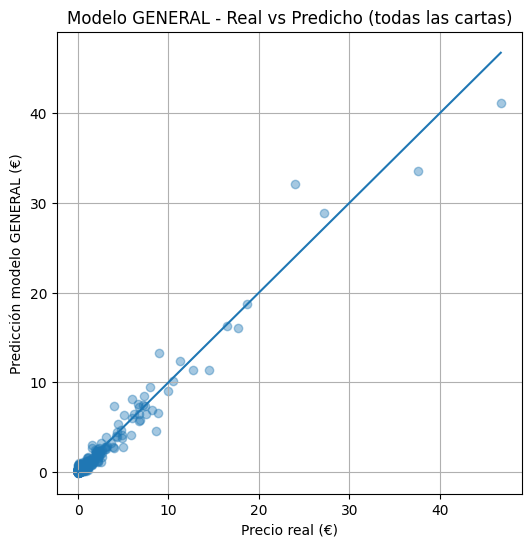

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(results['price_real'], results['pred_general'], alpha=0.4)
plt.plot([0, results['price_real'].max()],
         [0, results['price_real'].max()])
plt.xlabel("Precio real (€)")
plt.ylabel("Predicción modelo GENERAL (€)")
plt.title("Modelo GENERAL - Real vs Predicho (todas las cartas)")
plt.grid(True)
plt.show()


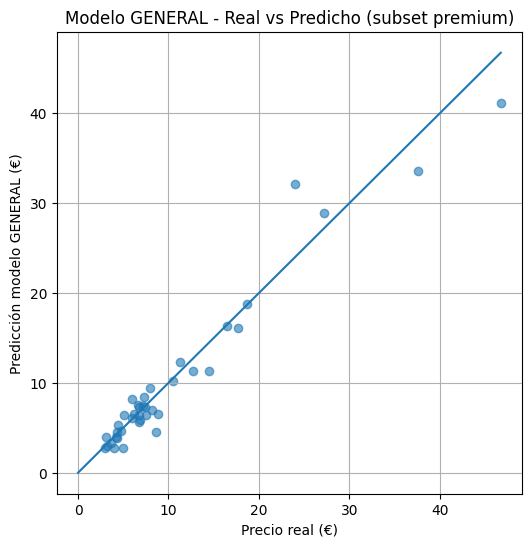

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(prem['price_real'], prem['pred_general'], alpha=0.6)
plt.plot([0, prem['price_real'].max()],
         [0, prem['price_real'].max()])
plt.xlabel("Precio real (€)")
plt.ylabel("Predicción modelo GENERAL (€)")
plt.title("Modelo GENERAL - Real vs Predicho (subset premium)")
plt.grid(True)
plt.show()


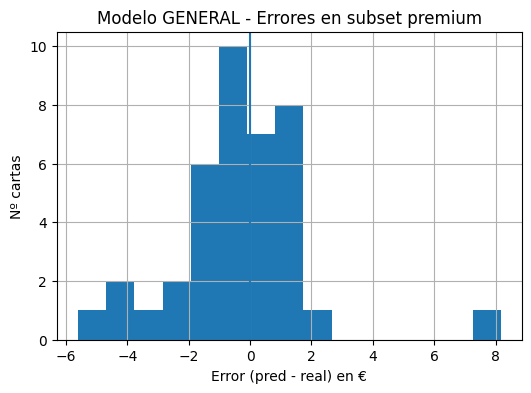

In [28]:
errors_gen_prem = y_pred_gen_prem - y_true_prem

plt.figure(figsize=(6,4))
plt.hist(errors_gen_prem, bins=15)
plt.axvline(0)
plt.xlabel("Error (pred - real) en €")
plt.ylabel("Nº cartas")
plt.title("Modelo GENERAL - Errores en subset premium")
plt.grid(True)
plt.show()


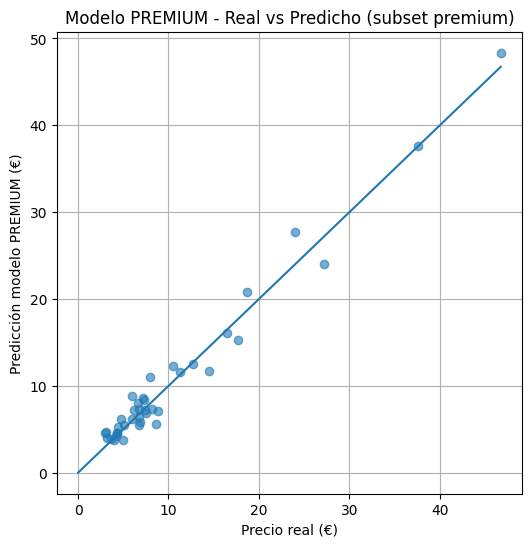

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(prem['price_real'], prem['pred_premium'], alpha=0.6)
plt.plot([0, prem['price_real'].max()],
         [0, prem['price_real'].max()])
plt.xlabel("Precio real (€)")
plt.ylabel("Predicción modelo PREMIUM (€)")
plt.title("Modelo PREMIUM - Real vs Predicho (subset premium)")
plt.grid(True)
plt.show()


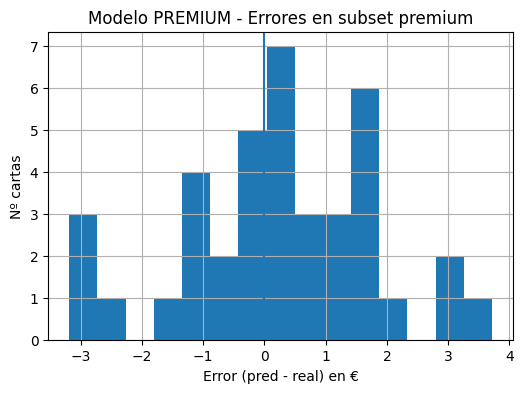

In [30]:
errors_prem_prem = y_pred_prem_prem - y_true_prem

plt.figure(figsize=(6,4))
plt.hist(errors_prem_prem, bins=15)
plt.axvline(0)
plt.xlabel("Error (pred - real) en €")
plt.ylabel("Nº cartas")
plt.title("Modelo PREMIUM - Errores en subset premium")
plt.grid(True)
plt.show()


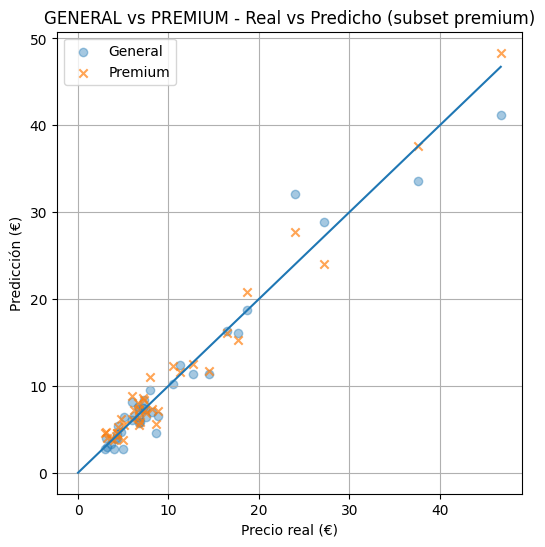

In [31]:
plt.figure(figsize=(6, 6))

plt.scatter(prem['price_real'], prem['pred_general'], alpha=0.4, label="General")
plt.scatter(prem['price_real'], prem['pred_premium'], alpha=0.7, marker='x', label="Premium")

plt.plot([0, prem['price_real'].max()],
         [0, prem['price_real'].max()])

plt.xlabel("Precio real (€)")
plt.ylabel("Predicción (€)")
plt.title("GENERAL vs PREMIUM - Real vs Predicho (subset premium)")
plt.legend()
plt.grid(True)
plt.show()


Pruebas de mejora del modelo híbrido

In [32]:
#FUNCIONES DE EVALUACIÓN DE MODELOS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def eval_model_general(model, X_test, y_test):
    """Evalúa un modelo en TODO el test (tanto baratas como caras)."""
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

def eval_model_premium(model, X_test, y_test, X_test_full):
    """
    Evalúa un modelo SOLO en cartas premium (según la misma regla de entrenamiento):
    rareza SR/SEC/P y precio real >= 3€.
    X_test_full = X_test con columna 'rarity' disponible.
    """
    # Aseguramos rarity
    Xtf = X_test_full.copy()
    if 'rarity' not in Xtf.columns:
        Xtf['rarity'] = df.loc[Xtf.index, 'rarity']
    Xtf['rarity'] = Xtf['rarity'].astype(str).str.upper()
    
    premium_rarities = ['SR', 'SEC', 'P']
    premium_mask_test = (
        Xtf['rarity'].isin(premium_rarities) &
        (y_test >= 3.0)
    )
    
    if premium_mask_test.sum() == 0:
        return None  # no hay cartas premium en test, raro pero por si acaso
    
    X_prem_test = Xtf[premium_mask_test]
    y_prem_test = y_test[premium_mask_test]
    
    y_pred_prem = model.predict(X_prem_test)
    mae = mean_absolute_error(y_prem_test, y_pred_prem)
    rmse = np.sqrt(mean_squared_error(y_prem_test, y_pred_prem))
    r2 = r2_score(y_prem_test, y_pred_prem)
    return mae, rmse, r2, premium_mask_test.sum()


In [34]:
#TUNNING DEL MODELO GENERAL

In [33]:
from catboost import CatBoostRegressor, Pool

# Aseguramos cat_cols están bien definidos (como ya hiciste)
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

train_pool_general = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_cols
)

valid_pool_general = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_cols
)

depth_list = [6, 8]
lr_list = [0.03, 0.05]
l2_list = [3, 5, 10]
bagtemp_list = [0.5, 1.0]

best_general_params = None
best_general_rmse = float('inf')
best_general_model = None

for depth in depth_list:
    for lr in lr_list:
        for l2 in l2_list:
            for bt in bagtemp_list:
                print(f"Probando GENERAL: depth={depth}, lr={lr}, l2={l2}, bagtemp={bt}")
                
                model_tmp = CatBoostRegressor(
                    loss_function='RMSE',
                    eval_metric='RMSE',
                    n_estimators=2500,     # algo alto, usamos early stopping
                    learning_rate=lr,
                    depth=depth,
                    l2_leaf_reg=l2,
                    bagging_temperature=bt,
                    random_seed=42,
                    od_type='Iter',
                    od_wait=80,
                    verbose=False
                )
                
                model_tmp.fit(
                    train_pool_general,
                    eval_set=valid_pool_general,
                    use_best_model=True
                )
                
                mae, rmse, r2 = eval_model_general(model_tmp, X_test, y_test)
                print(f" -> RMSE test: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
                
                if rmse < best_general_rmse:
                    best_general_rmse = rmse
                    best_general_params = (depth, lr, l2, bt)
                    best_general_model = model_tmp
                    print("   ** Nuevo mejor modelo GENERAL **")

print("\nMejores parámetros GENERAL:", best_general_params)
print("Mejor RMSE GENERAL:", best_general_rmse)


Probando GENERAL: depth=6, lr=0.03, l2=3, bagtemp=0.5
 -> RMSE test: 0.5366, MAE: 0.2090, R²: 0.9720
   ** Nuevo mejor modelo GENERAL **
Probando GENERAL: depth=6, lr=0.03, l2=3, bagtemp=1.0
 -> RMSE test: 0.5366, MAE: 0.2090, R²: 0.9720
Probando GENERAL: depth=6, lr=0.03, l2=5, bagtemp=0.5
 -> RMSE test: 0.4872, MAE: 0.1545, R²: 0.9769
   ** Nuevo mejor modelo GENERAL **
Probando GENERAL: depth=6, lr=0.03, l2=5, bagtemp=1.0
 -> RMSE test: 0.4872, MAE: 0.1545, R²: 0.9769
Probando GENERAL: depth=6, lr=0.03, l2=10, bagtemp=0.5
 -> RMSE test: 0.4862, MAE: 0.1893, R²: 0.9770
   ** Nuevo mejor modelo GENERAL **
Probando GENERAL: depth=6, lr=0.03, l2=10, bagtemp=1.0
 -> RMSE test: 0.4862, MAE: 0.1893, R²: 0.9770
Probando GENERAL: depth=6, lr=0.05, l2=3, bagtemp=0.5
 -> RMSE test: 0.5939, MAE: 0.2384, R²: 0.9657
Probando GENERAL: depth=6, lr=0.05, l2=3, bagtemp=1.0
 -> RMSE test: 0.5939, MAE: 0.2384, R²: 0.9657
Probando GENERAL: depth=6, lr=0.05, l2=5, bagtemp=0.5
 -> RMSE test: 0.5599, MAE: 

In [35]:
#TUNING DEL MODELO PREMIUM

In [36]:
# Definimos subset premium en train (misma regla de antes)
premium_rarities = ['SR', 'SEC', 'P']

X_train_premium = X_train[
    X_train['rarity'].isin(premium_rarities) & (y_train >= 3.0)
].copy()
y_train_premium = y_train.loc[X_train_premium.index]

train_pool_premium = Pool(
    data=X_train_premium,
    label=y_train_premium,
    cat_features=cat_cols
)

print("Tamaño dataset premium:", X_train_premium.shape)


Tamaño dataset premium: (191, 40)


In [37]:
depth_list_p = [6, 8]
lr_list_p = [0.03, 0.05]
l2_list_p = [1, 3, 5]

best_premium_params = None
best_premium_rmse = float('inf')
best_premium_model = None

for depth in depth_list_p:
    for lr in lr_list_p:
        for l2 in l2_list_p:
            print(f"Probando PREMIUM: depth={depth}, lr={lr}, l2={l2}")
            
            model_tmp = CatBoostRegressor(
                loss_function='RMSE',
                eval_metric='RMSE',
                n_estimators=2500,
                learning_rate=lr,
                depth=depth,
                l2_leaf_reg=l2,
                random_seed=42,
                od_type='Iter',
                od_wait=80,
                verbose=False
            )
            
            model_tmp.fit(
                train_pool_premium,
                eval_set=valid_pool_general,   # validación en el test general
                use_best_model=True
            )
            
            eval_prem = eval_model_premium(model_tmp, X_test, y_test, X_test)
            if eval_prem is None:
                print(" -> No hay cartas premium en test, saltando.")
                continue
            mae_p, rmse_p, r2_p, n_p = eval_prem
            print(f" -> RMSE premium test: {rmse_p:.4f}, MAE: {mae_p:.4f}, R²: {r2_p:.4f} (n={n_p})")
            
            if rmse_p < best_premium_rmse:
                best_premium_rmse = rmse_p
                best_premium_params = (depth, lr, l2)
                best_premium_model = model_tmp
                print("   ** Nuevo mejor modelo PREMIUM **")

print("\nMejores parámetros PREMIUM:", best_premium_params)
print("Mejor RMSE PREMIUM:", best_premium_rmse)


Probando PREMIUM: depth=6, lr=0.03, l2=1
 -> RMSE premium test: 1.4906, MAE: 1.1604, R²: 0.9743 (n=39)
   ** Nuevo mejor modelo PREMIUM **
Probando PREMIUM: depth=6, lr=0.03, l2=3
 -> RMSE premium test: 1.9115, MAE: 1.4484, R²: 0.9577 (n=39)
Probando PREMIUM: depth=6, lr=0.03, l2=5
 -> RMSE premium test: 1.6002, MAE: 1.2266, R²: 0.9704 (n=39)
Probando PREMIUM: depth=6, lr=0.05, l2=1
 -> RMSE premium test: 1.4484, MAE: 1.1306, R²: 0.9757 (n=39)
   ** Nuevo mejor modelo PREMIUM **
Probando PREMIUM: depth=6, lr=0.05, l2=3
 -> RMSE premium test: 1.5628, MAE: 1.2112, R²: 0.9717 (n=39)
Probando PREMIUM: depth=6, lr=0.05, l2=5
 -> RMSE premium test: 1.5340, MAE: 1.1106, R²: 0.9728 (n=39)
Probando PREMIUM: depth=8, lr=0.03, l2=1
 -> RMSE premium test: 1.6719, MAE: 1.2506, R²: 0.9677 (n=39)
Probando PREMIUM: depth=8, lr=0.03, l2=3
 -> RMSE premium test: 1.6919, MAE: 1.2617, R²: 0.9669 (n=39)
Probando PREMIUM: depth=8, lr=0.03, l2=5
 -> RMSE premium test: 1.9449, MAE: 1.4443, R²: 0.9562 (n=39)
P

In [38]:
#REASIGNACIÓN DE MODELOS A LOS NUEVOS PARÁMETROS

In [39]:
model_general = best_general_model

model_premium = best_premium_model


In [40]:
#EVALUACIÓN DE NUEVO MODELO HÍBRIDO

In [41]:
y_pred_hybrid = hybrid_predict(X_test)

mae_h = mean_absolute_error(y_test, y_pred_hybrid)
rmse_h = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
r2_h = r2_score(y_test, y_pred_hybrid)

print("=== Sistema Híbrido TUNING (General + Premium) ===")
print(f"MAE (€):   {mae_h:.4f}")
print(f"RMSE (€):  {rmse_h:.4f}")
print(f"R² precio: {r2_h:.4f}")


=== Sistema Híbrido TUNING (General + Premium) ===
MAE (€):   0.4904
RMSE (€):  1.2167
R² precio: 0.8559


In [42]:
results_h = X_test.copy()
results_h['price_real'] = y_test.values
results_h['price_pred'] = y_pred_hybrid

if 'rarity' not in results_h.columns:
    results_h['rarity'] = df.loc[results_h.index, 'rarity']

results_h['rarity'] = results_h['rarity'].astype(str).str.upper()

rarity_metrics_h = []

for r in ['C', 'U', 'R', 'SR', 'SEC', 'P']:
    subset = results_h[results_h['rarity'] == r]
    if len(subset) == 0:
        continue
    
    mae = mean_absolute_error(subset['price_real'], subset['price_pred'])
    rmse = np.sqrt(mean_squared_error(subset['price_real'], subset['price_pred']))
    
    rarity_metrics_h.append({
        'rarity': r,
        'n_cartas': len(subset),
        'MAE_€': mae,
        'RMSE_€': rmse
    })

rarity_metrics_h_df = pd.DataFrame(rarity_metrics_h).sort_values('rarity')
rarity_metrics_h_df


,rarity,n_cartas,MAE_€,RMSE_€
0,C,281,0.058463,0.228258
5,P,33,2.883722,3.217801
2,R,139,0.172919,0.611848
4,SEC,10,1.315562,1.506610
3,SR,72,2.591616,2.956484
1,U,192,0.110092,0.287418


In [43]:
#ANÁLISIS DE ERRORES DEL MODELO

In [44]:
import numpy as np
import pandas as pd

results = X_test.copy()

# Aseguramos rarity
if 'rarity' not in results.columns:
    results['rarity'] = df.loc[results.index, 'rarity']

results['rarity'] = results['rarity'].astype(str).str.upper()

# Precio real
results['price_real'] = y_test.values

# Predicción modelo general
results['pred_general'] = model_general.predict(X_test)

# Predicción modelo híbrido (ya la tienes calculada como y_pred_hybrid)
results['pred_hybrid'] = y_pred_hybrid

# Definimos rarezas premium
premium_rarities = ['SR', 'SEC', 'P']

# Misma regla que para entrenar premium (si quieres centrarte en las caras)
results['is_premium_train_rule'] = (
    results['rarity'].isin(premium_rarities) &
    (results['price_real'] >= 3.0)
)

# Predicción modelo premium SOLO donde aplica su regla
results['pred_premium'] = np.nan
mask_prem = results['is_premium_train_rule']
if mask_prem.any():
    results.loc[mask_prem, 'pred_premium'] = model_premium.predict(X_test[mask_prem])

# Errores del sistema híbrido
results['error_hybrid'] = results['pred_hybrid'] - results['price_real']
results['abs_error_hybrid'] = results['error_hybrid'].abs()

results.head()


,name_x,type,level,play_cost,evolution_cost,evolution_color,evolution_level,xros_req,color,color2,...,rarity_rank,year_added,month_added,price_real,pred_general,pred_hybrid,is_premium_train_rule,pred_premium,error_hybrid,abs_error_hybrid
1289,Gladimon,Digimon,4.0,5.0,2.0,Unknown,NaN,Unknown,Black,Unknown,...,0,2024,5,0.05,0.036624,0.036624,False,NaN,-0.013376,0.013376
120,AncientKazemon,Digimon,6.0,13.0,5.0,Unknown,NaN,Unknown,Yellow,Unknown,...,2,2024,5,0.18,0.325523,0.325523,False,NaN,0.145523,0.145523
839,Dinorexmon,Digimon,6.0,13.0,5.0,Red,NaN,Unknown,Red,Green,...,2,2024,5,0.04,0.209416,0.209416,False,NaN,0.169416,0.169416
1537,Hudiemon,Digimon,4.0,7.0,5.0,Unknown,NaN,[Digivolve] Lv.3 w/[CS] trait: Cost 4 \r\n[Dig...,Green,Yellow,...,5,2025,9,23.98,27.568854,25.584223,True,25.584223,1.604223,1.604223
2890,ShineGreymon: Burst Mode,Digimon,7.0,15.0,5.0,Unknown,NaN,[Burst Digivolve] [ShineGreymon]: By returning...,Red,Yellow,...,4,2024,5,3.65,3.040273,3.917999,True,3.917999,0.267999,0.267999


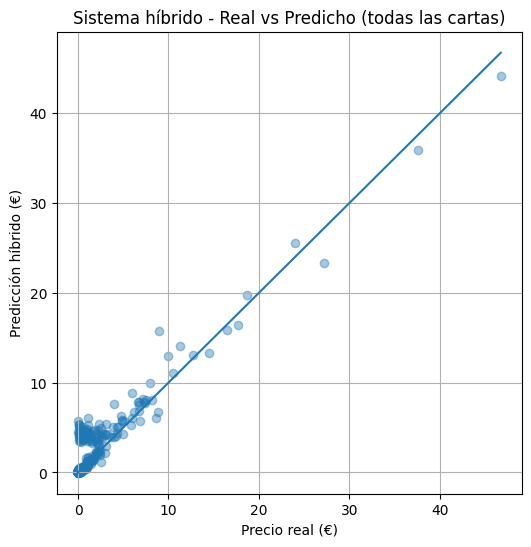

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(results['price_real'], results['pred_hybrid'], alpha=0.4)
plt.plot(
    [0, results['price_real'].max()],
    [0, results['price_real'].max()]
)
plt.xlabel("Precio real (€)")
plt.ylabel("Predicción híbrido (€)")
plt.title("Sistema híbrido - Real vs Predicho (todas las cartas)")
plt.grid(True)
plt.show()


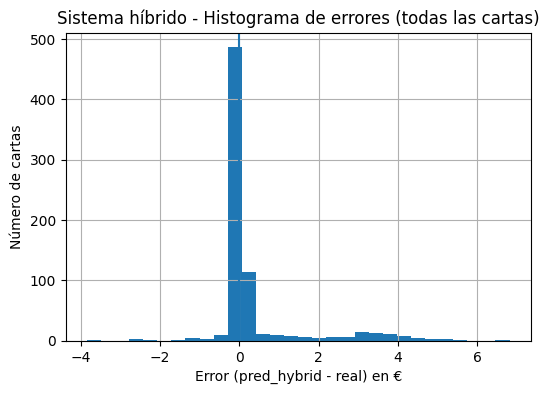

In [46]:
plt.figure(figsize=(6, 4))
plt.hist(results['error_hybrid'], bins=30)
plt.axvline(0)
plt.xlabel("Error (pred_hybrid - real) en €")
plt.ylabel("Número de cartas")
plt.title("Sistema híbrido - Histograma de errores (todas las cartas)")
plt.grid(True)
plt.show()


C:\Users\alexa\AppData\Local\Temp\ipykernel_19276\978057350.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=labels_box, showfliers=True)


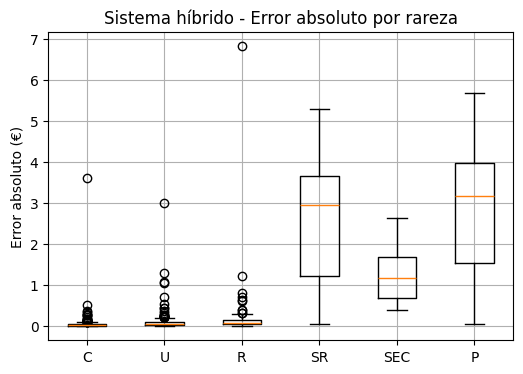

In [47]:
rarity_order = ['C', 'U', 'R', 'SR', 'SEC', 'P']

data_box = []
labels_box = []

for r in rarity_order:
    subset = results[results['rarity'] == r]
    if len(subset) == 0:
        continue
    data_box.append(subset['abs_error_hybrid'].values)
    labels_box.append(r)

plt.figure(figsize=(6, 4))
plt.boxplot(data_box, labels=labels_box, showfliers=True)
plt.ylabel("Error absoluto (€)")
plt.title("Sistema híbrido - Error absoluto por rareza")
plt.grid(True)
plt.show()


In [48]:
prem = results[results['is_premium_train_rule']].copy()

y_true_prem = prem['price_real'].values
y_gen_prem = prem['pred_general'].values
y_prem_prem = prem['pred_premium'].values
y_hyb_prem = prem['pred_hybrid'].values


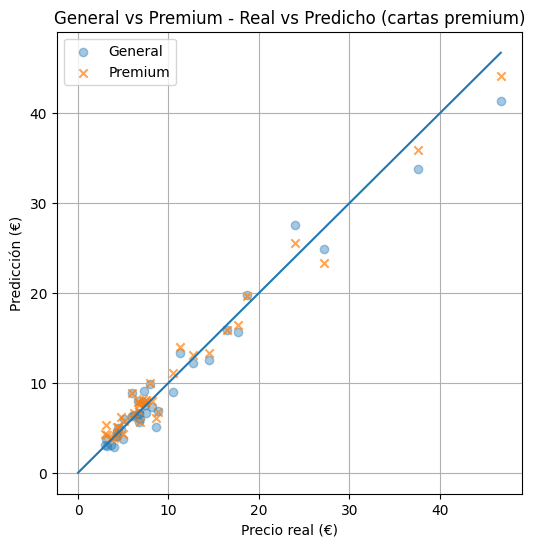

In [49]:
plt.figure(figsize=(6, 6))

# General
plt.scatter(prem['price_real'], prem['pred_general'], alpha=0.4, label="General")

# Premium (solo cartas premium)
plt.scatter(prem['price_real'], prem['pred_premium'], alpha=0.7, marker='x', label="Premium")

# Línea perfecta
max_val = max(prem['price_real'].max(), prem[['pred_general','pred_premium']].max().max())
plt.plot([0, max_val], [0, max_val])

plt.xlabel("Precio real (€)")
plt.ylabel("Predicción (€)")
plt.title("General vs Premium - Real vs Predicho (cartas premium)")
plt.legend()
plt.grid(True)
plt.show()


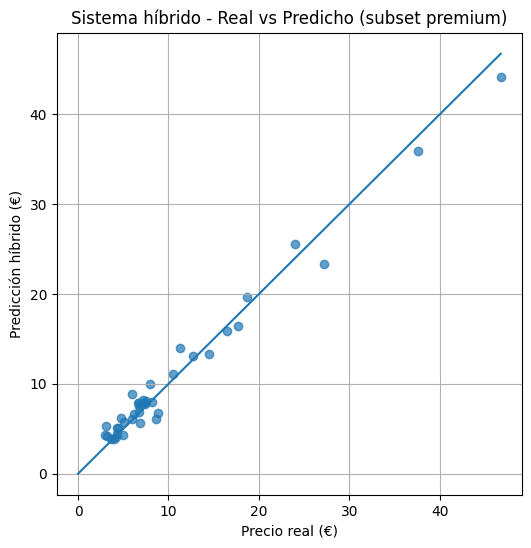

In [50]:
plt.figure(figsize=(6, 6))
plt.scatter(prem['price_real'], prem['pred_hybrid'], alpha=0.7)
plt.plot([0, prem['price_real'].max()], [0, prem['price_real'].max()])

plt.xlabel("Precio real (€)")
plt.ylabel("Predicción híbrido (€)")
plt.title("Sistema híbrido - Real vs Predicho (subset premium)")
plt.grid(True)
plt.show()


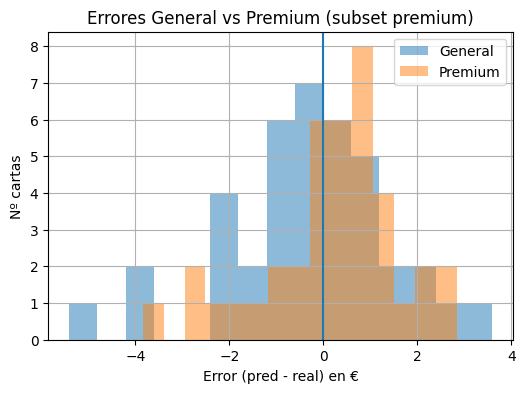

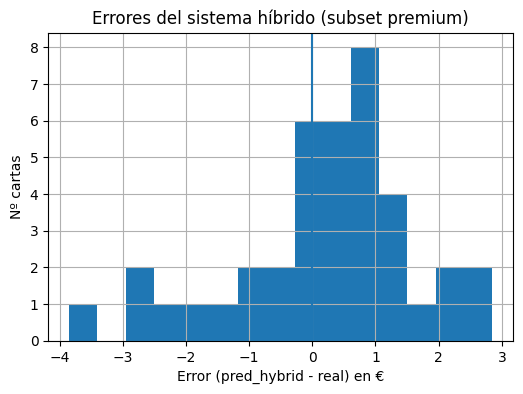

In [51]:
error_gen_prem = y_gen_prem - y_true_prem
error_prem_prem = y_prem_prem - y_true_prem
error_hyb_prem = y_hyb_prem - y_true_prem

plt.figure(figsize=(6, 4))
plt.hist(error_gen_prem, bins=15, alpha=0.5, label="General")
plt.hist(error_prem_prem, bins=15, alpha=0.5, label="Premium")
plt.axvline(0)
plt.xlabel("Error (pred - real) en €")
plt.ylabel("Nº cartas")
plt.title("Errores General vs Premium (subset premium)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(error_hyb_prem, bins=15)
plt.axvline(0)
plt.xlabel("Error (pred_hybrid - real) en €")
plt.ylabel("Nº cartas")
plt.title("Errores del sistema híbrido (subset premium)")
plt.grid(True)
plt.show()


In [53]:
#EL MODELO DESPUÉS DEL TUNNING MEJORA EN LAS CARTAS "PREMIUM" SIN EMBARGO EMPEORA EN LAS CARTAS "BÁSICAS" POR LO QUE SELECCIONAMOS COMO
# MODELO GENERAL EL MODELO
#INICAL Y MANTENEMOS EL TUNNING PARA EL MODELO "PREMIUM" PARA MAXIMIZAR LOS RESULTADOS.

In [57]:
model_general_final = model_general
model_premium_final = model_premium